In [1]:
import pickle
import numpy as np
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import os
import json
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
import open3d as o3d

In [2]:
def dbm_to_mV(dbm,Z=50):
    return 1000*np.sqrt(Z/1000)*(10**(dbm/10))

# def dbm_to_V(dbm,ro=50):
#     # return np.sqrt((ro/1000)*(10**(dbm/10)))
#     return watts_to_V(dbm_to_W(dbm), ro=ro)

# def watts_to_V(pw, ro=50):
#     return np.sqrt(pw*ro)

# def V_to_watts(V,rho=50):
#     return V**2/(rho)

# def mV_to_dbm(mV, Z=50):
#     return 20 * np.log10(mV / (1000 * np.sqrt(Z / 1000)))

# def dbm_to_W(dbm): # check once, this formula might only be true for db to W
#     return 10**(dbm/10)  * 1e-3 #Watts


In [3]:
# ch_list = ['1', '3', '4', '6', '7','8']



# if rx=="1":
#     tx_for_vna='v32-3'
#     rx_for_pv='v32-5'
# else: # todo make this as an argument of the function
#     tx_for_vna='v32-5'
#     rx_for_pv='v32-3'

# phases=[]
# amps = []
# attns = []
# for ch in ch_list:

#     tx_dat = read_network_analyzer_file(
#                                 f'{calibration_path}/VNA_Dec2025/'+str(tx_for_vna)+'_channel_b\'' + f"ch_{str(ch)}" + '\'_vna_pwr_15.csv')
#     sl_tx = tx_dat[1] * np.exp(1j * tx_dat[2])
#     gamma = (s2z(sl_tx) - s2z(np.conj(50))) / (s2z(sl_tx) + s2z(50))
#     gamma=1-gamma

#     freq_a = tx_dat[0]
#     p = np.polyfit(freq_a, np.unwrap(np.angle(gamma)), 1)
#     phases.append(np.polyval(p, freq))

#     p = np.polyfit(freq_a, abs(gamma), 1)
#     attns.append(np.polyval(p, freq))
    
#     rx_pv=pickle.load(open(f"{calibration_path}/PV_data_Dec2025/{rx_for_pv}_pv_polynomials_rx.pkl","rb"))
#     dbm_corrected=np.polyval(rx_pv[freq/1e6]["polynomial"],np.log(adc_out))
#     mV_corrected=dbm_to_mV(dbm_corrected)
#     amps.append(mV_corrected)

# th = get_theta(amps, attns, phases) 


# Get train data

In [4]:
with open("processedDF.pkl",'rb') as f:
    processedDF = pickle.load(f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Dist (m)
0,Tag1,Tag2,"[658.69, 194.74, 195.05, 194.9, 194.59, 194.67...",194.900,199.820,210.495,184.900,187.340,192.530,845,0,1,1.185
1,Tag1,Tag2,"[658.69, 194.74, 195.05, 194.9, 194.59, 194.67...",195.085,199.435,210.690,185.210,187.800,192.265,845,0,1,1.185
2,Tag1,Tag2,"[658.69, 194.74, 195.05, 194.9, 194.59, 194.67...",195.090,200.045,210.540,184.900,187.535,192.265,845,0,1,1.185
3,Tag1,Tag2,"[658.69, 194.74, 195.05, 194.9, 194.59, 194.67...",195.120,199.705,210.610,185.170,187.305,192.760,845,0,1,1.185
4,Tag1,Tag2,"[658.69, 194.74, 195.05, 194.9, 194.59, 194.67...",195.165,200.770,211.415,185.400,188.070,193.140,845,0,1,1.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,Tag2,Tag1,"[43.98, 19.19, 16.37, 18.88, 16.21, 19.87, 17....",18.880,23.120,15.945,17.660,21.670,25.065,945,7,1,1.185
876,Tag2,Tag1,"[43.98, 19.19, 16.37, 18.88, 16.21, 19.87, 17....",16.480,20.025,13.655,16.865,20.410,25.105,945,7,1,1.185
877,Tag2,Tag1,"[43.98, 19.19, 16.37, 18.88, 16.21, 19.87, 17....",16.515,20.485,14.230,16.100,21.290,25.520,945,7,1,1.185
878,Tag2,Tag1,"[43.98, 19.19, 16.37, 18.88, 16.21, 19.87, 17....",18.155,21.135,13.690,16.555,20.945,25.295,945,7,1,1.185


In [5]:
# In a set of 10 MPPs first 5 are from tag1 to tag2, next 5 are from tag2 to tag1. 
# These 5 mpps can be cross multiplied to get 25 phase measurements.

#Dims: (no of experiments (locations), number of unique frequencies, two dims (phase and amp), 25 values (5mpps X 5mpp))
FINAL_DATA=np.zeros([np.max(processedDF['Run Exp Num'])+1, len(np.unique(processedDF["Frequency (MHz)"])), 2, 25])

calibration_path="/Users/manavjeet/git/T2TExperiments/coba/calibrations"
ch_list = ['1', '3', '4', '6', '7','8']
freq_idx=0


for i in range(0,len(processedDF),10):
    if freq_idx>=FINAL_DATA.shape[1]:
        freq_idx=0

    DFoI_1 = processedDF[i:i+5]
    DFoI_2 = processedDF[i+5:i+10]
    
    #Check if the frequency used in same across MPPs
    assert(DFoI_1.iloc[0]['Frequency (MHz)']==DFoI_2.iloc[-1]['Frequency (MHz)'])
    
    #Check if the exp no used in same across MPPs
    assert(DFoI_1.iloc[0]['Run Exp Num']==DFoI_2.iloc[-1]['Run Exp Num'])
    
    freq=DFoI_1.iloc[0]['Frequency (MHz)']*1e6
    exp_no=DFoI_1.iloc[0]['Run Exp Num']
    # if freq!=915e6:
    #     continue
    all_channel_atten=[]
    all_channel_phase=[]
    for row1 in range(5):
        for row2 in range(5):
            # print(ff)
            # ff+=1
            t1_row = DFoI_1.iloc[row1]
            t2_row = DFoI_2.iloc[row2]
            # print(t2_row)
            
            thetas=[]
            amplitudes=[]
            voltages=[]
            for rx in ['1','2']:
                if rx=="1":
                    tx_for_vna='v32-3'
                    rx_for_pv='v32-5'
                    # rx_for_vna='tag4'
                    # tx_for_vna='tag5'
                    # rx_for_pv='tag4'
                else: # todo make this as an argument of the function
                    tx_for_vna='v32-5'
                    rx_for_pv='v32-3'
                    # rx_for_vna='tag5'
                    # tx_for_vna='tag4'
                    # rx_for_pv='tag1'

                phases=[]
                amps = []
                attns = []
                for ch in ch_list:
                    if rx=='1':
                        adc_out=t1_row[f"Phase{ch}"]
                    else:
                        adc_out=t2_row[f"Phase{ch}"]
                    
                    tx_dat = read_network_analyzer_file(
                            f'{calibration_path}/VNA_Dec2025/'+str(tx_for_vna)+'_channel_b\'' + f"ch_{str(ch)}" + '\'_vna_pwr_15.csv')
                    
                    # tx_dat = read_network_analyzer_file(
                    #         f'{calibration_path}/VNA_Oct2024/'+str(tx_for_vna)+'_channel_b\'' + f"ch_{str(ch)}" + '\'_vna_pwr_15.csv')
                    sl_tx = tx_dat[1] * np.exp(1j * tx_dat[2])
                    gamma = (s2z(sl_tx) - s2z(np.conj(50))) / (s2z(sl_tx) + s2z(50))
                    gamma=1-gamma

                    freq_all = tx_dat[0]
                    p = np.polyfit(freq_all, np.unwrap(np.angle(gamma)), 1)
                    phases.append(np.polyval(p, freq))

                    p = np.polyfit(freq_all, abs(gamma), 1)
                    attns.append(np.polyval(p, freq))
                    
                    rx_pv=pickle.load(open(f"{calibration_path}/PV_data_Dec2025/{rx_for_pv}_pv_polynomials_rx.pkl","rb"))
                    # rx_pv=pickle.load(open(f"{calibration_path}/PV_data_Aug2024/{rx_for_pv}_pv_polynomials_rx.pkl","rb"))
                    dbm_corrected=np.polyval(rx_pv[freq/1e6]["polynomial"],np.log(adc_out))
                    mV_corrected=dbm_to_mV(dbm_corrected)
                    amps.append(mV_corrected)
                    
                voltages.append(np.mean(amps))
                
                th = get_theta(amps, attns, phases) 
                thetas.append(th)
                t2tamp = get_amplitude(amps, attns, phases) 
                amplitudes.append(t2tamp)
            
            channel_phase=((thetas[0]+thetas[1])/2) % np.pi
            channel_atten=(amplitudes[0]/voltages[1] + amplitudes[1]/voltages[0])/2
            
            all_channel_phase.append(channel_phase)
            all_channel_atten.append(channel_atten)
            
            # print(f"Channel phase: {channel_phase}")
            # print(f"Channel atten: {channel_atten}")
            # print(f"Freq = {freq}")
            # print(thetas)
            # print(amplitudes)
            # print(voltages)
            # print()            
            # break
    #     break
    # break
    all_channel_atten=np.array(all_channel_atten)
    all_channel_phase=np.array(all_channel_phase)
    
    FINAL_DATA[exp_no, freq_idx, 0,:]=all_channel_atten
    FINAL_DATA[exp_no, freq_idx, 1,:]=all_channel_phase
    
    # print(len(all_channel_atten))
    
    freq_idx+=1

In [6]:
FINAL_DATA

array([[[[0.03310323, 0.03609461, 0.03116365, ..., 0.03127008,
          0.03333725, 0.03303577],
         [1.38867332, 1.42568777, 1.39186391, ..., 1.38693145,
          1.41986238, 1.3903725 ]],

        [[0.06764343, 0.05314798, 0.06122057, ..., 0.06152032,
          0.05844086, 0.05897767],
         [2.22257068, 2.31148954, 2.24869786, ..., 2.28864388,
          2.25527312, 2.28905381]],

        [[0.01400333, 0.04320843, 0.06309958, ..., 0.06412499,
          0.05386452, 0.05425586],
         [2.54177055, 2.56736215, 2.71574401, ..., 2.72840193,
          2.61293965, 2.71226024]],

        ...,

        [[0.03536492, 0.03643008, 0.0382355 , ..., 0.03859634,
          0.03586308, 0.03608958],
         [1.51882018, 1.5366762 , 1.52448048, ..., 1.54667593,
          1.53959997, 1.56504493]],

        [[0.1243571 , 0.12285757, 0.1372649 , ..., 0.13743606,
          0.12111421, 0.13792067],
         [1.78730535, 1.81596641, 1.81161808, ..., 1.81663225,
          1.82012561, 1.83158334]

In [7]:
np.save("X_processed.npy", FINAL_DATA)

In [8]:
d=1.185
theta=((2*np.pi*d*845e6)/3e8)%np.pi
print(theta)

2.1221458374999074


# Get label data

In [9]:
experiment_dir_path="/Users/manavjeet/git/Backscatter_UGV_ws/experiments"
experiment_name = os.path.basename(os.getcwd())

In [10]:
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def extract_pos_odom(data, gt=None, plotting=False):
    pos_expmts=[]
    pos_all=[]
    
    orientation_expmts=[]
    orientation_all=[]
    
    for idx in range(len(data)):
        x=data[idx]["odom"]["pose"]["pose"]['position']['x']
        y=data[idx]["odom"]["pose"]["pose"]['position']['y']
        z=data[idx]["odom"]["pose"]["pose"]['position']['z']
        pos_all.append([x,y,z])
        
        o_x=data[idx]["odom"]["pose"]["pose"]['orientation']['x']
        o_y=data[idx]["odom"]["pose"]["pose"]['orientation']['y']
        o_z=data[idx]["odom"]["pose"]["pose"]['orientation']['z']
        # o_w=0
        o_w=data[idx]["odom"]["pose"]["pose"]['orientation']['w']
        orientation_all.append([o_x,o_y,o_z,o_w])

        if data[idx]["expmt_flag"]:
            pos_expmts.append([x,y,z])
            orientation_expmts.append([o_x,o_y,o_z,o_w])

    return pos_expmts, pos_all, orientation_expmts, orientation_all

def get_dists_from_point(mesh, points, orientations, dirs, verbose=True):
    
    # --- 0. MODIFY POSITIONS AND ORIENTATIONS ---
    
    # A. Raise the points by 1 meter (Assuming Z is Up)
    # We use copy() to avoid modifying the original array outside the function
    points=np.array(points)
    points = points.copy()
    points[:, 2] += 1.0
    
    # B. Make orientations parallel to ground (Leveling)
    # 1. Convert Quaternions to Euler angles (Z-Y-X sequence usually isolates Yaw-Pitch-Roll)
    r = R.from_quat(orientations)
    euler = r.as_euler('zyx', degrees=False)
    
    # 2. Keep only the Yaw (rotation around Z), set Pitch (Y) and Roll (X) to 0
    # euler[:, 0] is Z-axis rotation (Yaw)
    # euler[:, 1] is Y-axis rotation (Pitch) -> Set to 0
    # euler[:, 2] is X-axis rotation (Roll)  -> Set to 0
    euler[:, 1] = 0
    euler[:, 2] = 0
    
    # 3. Convert back to Quaternions
    orientations = R.from_euler('zyx', euler).as_quat()


    # --- 1. SETUP & VISUALIZATION OF ORIGINS ---
    origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color([1, 1, 1]) # White dots for origin points

    
    # --- 2. RAYCASTING LOGIC ---
    num_dirs = dirs.shape[1] 
    
    # Repeat data for vectorization
    points_rep_rays = np.repeat(points, num_dirs, axis=0)
    quats_rep_rays = np.repeat(orientations, num_dirs, axis=0)
    
    # Use dirs[0] directly if dirs shape is (1, M, 3)
    dirs_local_rep = np.tile(dirs[0], (len(points), 1))

    # Apply Rotation
    r_rays = R.from_quat(quats_rep_rays)
    dirs_global = r_rays.apply(dirs_local_rep)

    # Cast Rays
    rays_tensor = o3d.core.Tensor(
        np.concatenate([points_rep_rays, dirs_global], axis=1),
        dtype=o3d.core.Dtype.Float32
    )

    scene = o3d.t.geometry.RaycastingScene()
    mesh_t = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene.add_triangles(mesh_t)
    
    results = scene.cast_rays(rays_tensor)
    t_hit = results['t_hit'].numpy()
    t_norm = results['primitive_normals'].numpy()


    # --- 3. VISUALIZE RAYS ---
    viz_lengths = t_hit.copy()
    viz_lengths[np.isinf(viz_lengths)] = 0.5 
    # viz_lengths[:] = 0
    
    ray_ends = points_rep_rays + (dirs_global * viz_lengths.reshape(-1, 1))
    
    ray_lines = o3d.geometry.LineSet()
    all_ray_points = np.vstack((points_rep_rays, ray_ends))
    
    num_total_rays = len(points_rep_rays)
    ray_indices = [[i, i + num_total_rays] for i in range(num_total_rays)]
    
    ray_lines.points = o3d.utility.Vector3dVector(all_ray_points)
    ray_lines.lines = o3d.utility.Vector2iVector(ray_indices)
    
    # Cyan for hit, White for miss
    ray_colors = [[0, 1, 1] if not np.isinf(d) else [1, 1, 1] for d in t_hit]
    ray_lines.colors = o3d.utility.Vector3dVector(ray_colors)


    # --- 4. VISUALIZE ORIENTATIONS (CUSTOM BASIS) ---
    
    axis_len = 0.3
    
    # DEFINING YOUR CUSTOM LOCAL AXES
    # Red=Y(Local), Green=-X(Local), Blue=Z(Local)
    custom_basis = np.array([
        [0, 1, 0], 
        [-1, 0, 0], 
        [0, 0, 1]
    ]) * axis_len
    
    # 3 lines per point
    arrow_starts = np.repeat(points, 3, axis=0)
    
    # Tile the custom basis for every point
    local_axes = np.tile(custom_basis, (len(points), 1))
    
    # Rotate these custom axes by the NEW leveled quaternion
    quats_rep_axes = np.repeat(orientations, 3, axis=0)
    r_axes = R.from_quat(quats_rep_axes)
    global_axes = r_axes.apply(local_axes)
    
    arrow_ends = arrow_starts + global_axes
    
    orient_lines = o3d.geometry.LineSet()
    all_arrow_points = np.vstack((arrow_starts, arrow_ends))
    
    num_arrows = len(arrow_starts)
    arrow_indices = [[i, i + num_arrows] for i in range(num_arrows)]
    
    orient_lines.points = o3d.utility.Vector3dVector(all_arrow_points)
    orient_lines.lines = o3d.utility.Vector2iVector(arrow_indices)
    
    # Colors: R, G, B repeating
    arrow_colors = np.tile([[1, 0, 0], [0, 1, 0], [0, 0, 1]], (len(points), 1))
    orient_lines.colors = o3d.utility.Vector3dVector(arrow_colors)

    if verbose:
        # --- 5. DRAW ---
        print("Distances:", t_hit)
        print("Norms", t_norm)
        o3d.visualization.draw_geometries([mesh, origin_frame, pcd, ray_lines, orient_lines])

    return t_hit.reshape([len(t_hit)//dirs.shape[1], dirs.shape[1]]), t_norm.reshape([t_norm.shape[0]//dirs.shape[1], dirs.shape[1], t_norm.shape[1]])


def plot_poses_flat(pos_all, orientation_all):
    pos = np.array(pos_all)
    orient = np.array(orientation_all)
    
    x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
    
    # 1. Convert Quaternions to Euler angles
    # 'zyx' is a common convention; 'z' is the yaw we want to keep.
    rotations = R.from_quat(orient)
    euler_angles = rotations.as_euler('zyx', degrees=False)
    
    # 2. Zero out the Pitch and Roll
    # In 'zyx' convention: index 0 is Yaw, 1 is Pitch, 2 is Roll
    euler_angles[:, 1] = 0  # Zero Pitch (elevation)
    euler_angles[:, 2] = 0  # Zero Roll
    
    # 3. Create a new rotation object with only the Yaw
    flat_rotations = R.from_euler('zyx', euler_angles, degrees=False)
    
    # 4. Get the new direction vectors (Forward = X-axis)
    direction = flat_rotations.apply([1, 0, 0])
    u, v, w = direction[:, 0], direction[:, 1], direction[:, 2]

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, color='blue', label='Positions', s=20)
    
    # Note: 'w' (the z-component of the arrow) should now be 0 
    ax.quiver(x, y, z, u, v, w, length=0.5, normalize=True, color='red', alpha=0.8)

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Path with Zero Elevation (Yaw Only)')
    
    # Set view to see the "flatness" clearly
    ax.view_init(elev=20, azim=45)
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_zlim([-3,3])
    plt.show()


In [11]:
pos_exp, pos_all, orientation_exp, orientation_all = extract_pos_odom(load_json(f"{experiment_dir_path}/{experiment_name}/{experiment_name}.json"), plotting=False)
mesh = o3d.io.read_triangle_mesh(f'{experiment_dir_path}/{experiment_name}/point_cloud_out/final_mesh.ply')

# Only look at two dimentional north south west east direction
dirs = np.array([[
    [1., 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
]])

t_hit, t_norm = get_dists_from_point(mesh, pos_exp, orientation_exp, dirs,verbose=False)
print(dirs.shape)
print(t_hit.shape)
print(t_norm.shape)

np.save("Y_dist.npy", t_hit)
np.save("Y_norm.npy", t_norm)


(1, 4, 3)
(8, 4)
(8, 4, 3)


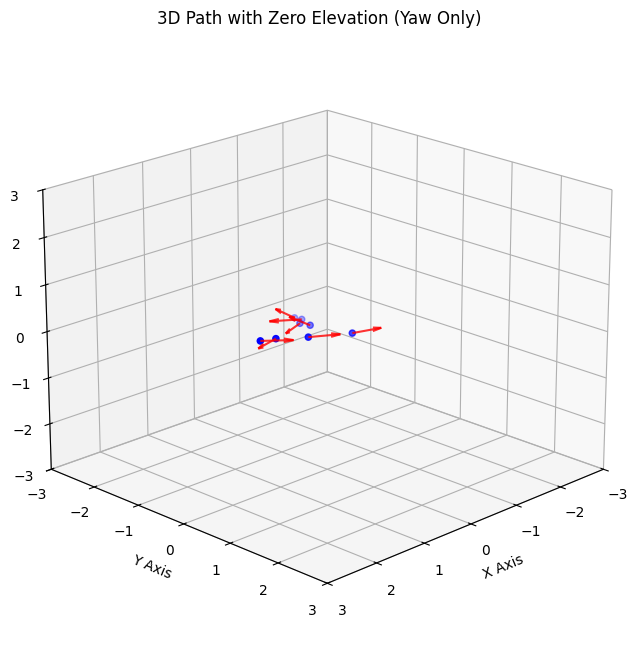

In [12]:
plot_poses_flat(pos_exp, orientation_exp)
